# Road Follower - Train Model

In this notebook we will train a neural network to take an input image, and output a set of x, y values corresponding to a target.

We will be using PyTorch deep learning framework to train ResNet18 neural network architecture model for road follower application.

In [1]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import glob
import PIL.Image
import os
import numpy as np
import ipywidgets

### Download and extract data

Before you start, you should upload the ``road_following_<Date&Time>.zip`` file that you created in the ``data_collection.ipynb`` notebook on the robot. 

> If you're training on the JetBot you collected data on, you can skip this!

You should then extract this dataset by calling the command below:

In [2]:
# !unzip -q road_following.zip

You should see a folder named ``dataset_all`` appear in the file browser.

### Create Dataset Instance

Here we create a custom ``torch.utils.data.Dataset`` implementation, which implements the ``__len__`` and ``__getitem__`` functions.  This class
is responsible for loading images and parsing the x, y values from the image filenames.  Because we implement the ``torch.utils.data.Dataset`` class,
we can use all of the torch data utilities :)

We hard coded some transformations (like color jitter) into our dataset.  We made random horizontal flips optional (in case you want to follow a non-symmetric path, like a road
where we need to 'stay right').  If it doesn't matter whether your robot follows some convention, you could enable flips to augment the dataset.

In [3]:
def get_x(path, width):
    """Gets the x value from the image filename"""
    return (float(int(path.split("_")[1])) - width/2) / (width/2)

def get_y(path, height):
    """Gets the y value from the image filename"""
    return (float(int(path.split("_")[2])) - height/2) / (height/2)

class XYDataset(torch.utils.data.Dataset):
    
    def __init__(self, directory, random_hflips=False):
        self.directory = directory
        self.random_hflips = random_hflips
        self.image_paths = glob.glob(os.path.join(self.directory, '*.jpg'))
        self.color_jitter = transforms.ColorJitter(0.3, 0.3, 0.3, 0.3)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        
        image = PIL.Image.open(image_path)
        width, height = image.size
        x = float(get_x(os.path.basename(image_path), width))
        y = float(get_y(os.path.basename(image_path), height))
      
        if float(np.random.rand(1)) > 0.5:
            image = transforms.functional.hflip(image)
            x = -x
        
        image = self.color_jitter(image)
        image = transforms.functional.resize(image, (224, 224))
        image = transforms.functional.to_tensor(image)
        image = image.numpy()[::-1].copy()
        image = torch.from_numpy(image)
        image = transforms.functional.normalize(image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
        return image, torch.tensor([x, y]).float()
    
dataset = XYDataset('dataset_xy', random_hflips=False)

### Split dataset into train and test sets
Once we read dataset, we will split data set in train and test sets. In this example we split train and test a 90%-10%. The test set will be used to verify the accuracy of the model we train.

In [4]:
test_percent = 0.1
num_test = int(test_percent * len(dataset))
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset) - num_test, num_test])

### Create data loaders to load data in batches

We use ``DataLoader`` class to load data in batches, shuffle data and allow using multi-subprocesses. In this example we use batch size of 64. Batch size will be based on memory available with your GPU and it can impact accuracy of the model.

In [5]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=0
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=0
)

### Define Neural Network Model 

We use ResNet-18 model available on PyTorch TorchVision. 

In a process called transfer learning, we can repurpose a pre-trained model (trained on millions of images) for a new task that has possibly much less data available.


More details on ResNet-18 : https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py

More Details on Transfer Learning: https://www.youtube.com/watch?v=yofjFQddwHE 

In [6]:
model = models.resnet18(pretrained=True)
# model = models.resnet101(pretrained=True)

ResNet model has fully connect (fc) final layer with 512 as ``in_features`` and we will be training for regression thus ``out_features`` as 1

Finally, we transfer our model for execution on the GPU

In [7]:
# model.fc = torch.nn.Linear(512, 2)
model.fc = torch.nn.Linear(model.fc.in_features, 2)
device = torch.device('cuda')
model = model.to(device)

### Train Regression:

We train for 70 epochs and save best model if the loss is reduced. 

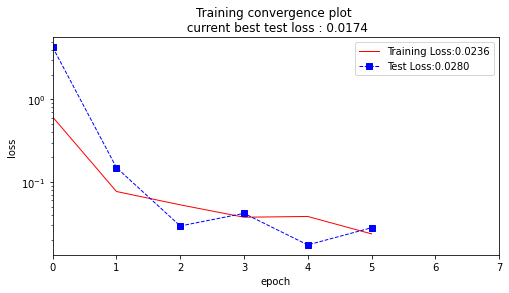

Training performance of the model at 6th epoch --- training lose: 0.023608, test loss: 0.027998


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output

fig, ax = plt.subplots(figsize=(8, 4))
font = {'weight': 'normal', 'size': 10}

def plot_loss(loss_data, best_loss):
    plt.cla()
    epochs = range(len(loss_data))
    ld_train = [ld[0] for ld in loss_data]
    ld_test = [ld[1] for ld in loss_data]
    ax.semilogy(epochs, ld_train, "r-", linewidth=1.0, label="Training Loss:{:.4f}".format(ld_train[-1]))
    ax.semilogy(epochs, ld_test, 'bs--', linewidth=1.0, label="Test Loss:{:.4f}".format(ld_test[-1]))

    ax.set_xlim(0, int(epochs[-1]*1.1) + 1)
    xlim = epochs[-1] + 2
    ax.set_xlim(0, xlim)
    plt.legend()
    plt.title("Training convergence plot \n current best test loss : {:.4f}".format(best_loss))
    plt.xlabel('epoch', fontdict=font)
    plt.ylabel('loss', fontdict=font)

    display(fig)
    
NUM_EPOCHS = 70
BEST_MODEL_PATH = 'best_steering_model_xy.pth'
best_loss = 1e9

optimizer = optim.Adam(model.parameters())
loss_data = []

for epoch in range(NUM_EPOCHS):
    
    model.train()
    train_loss = 0.0
    for images, labels in iter(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = F.mse_loss(outputs, labels)
        train_loss += float(loss)
        loss.backward()
        optimizer.step()
    train_loss /= len(train_loader)
    
    model.eval()
    test_loss = 0.0
    for images, labels in iter(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = F.mse_loss(outputs, labels)
        test_loss += float(loss)
    test_loss /= len(test_loader)

   
    if test_loss < best_loss:
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        best_loss = test_loss
    
    loss_data.append([train_loss, test_loss])
    plot_loss(loss_data, best_loss)
    print('Training performance of the model at %ith epoch --- training lose: %f, test loss: %f' \
          % (epoch+1, train_loss, test_loss))
    clear_output(wait=True)
 

Once the model is trained, it will generate ``best_steering_model_xy.pth`` file which you can use for inferencing in the live demo notebook.

If you trained on a different machine other than JetBot, you'll need to upload this to the JetBot to the ``road_following`` example folder.